In [28]:
import numpy as np
import pandas as pd
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import time
from astropy.coordinates import GeocentricMeanEcliptic
from astropy.coordinates import HeliocentricMeanEcliptic
from astropy.coordinates import HeliocentricTrueEcliptic
from astropy.coordinates import GeocentricTrueEcliptic
from astropy.coordinates import BarycentricTrueEcliptic
from astropy.coordinates import BarycentricMeanEcliptic
from astropy import coordinates 
import astropy

'''
    NAME:
         convert_to_primary_centric
         
    PURPOSE:
         This function takes a parameter Dataframe in RA/DEC, and converts it to Latitude 
         and Longitude, while also converting the dates to Primary-Centric Julian dates
         
    CALLING SEQUENCE:
         convert_to_primary_centric(paramsDF, objectName)
   
    INPUTS
          paramsDF - A dataframe of the observed positional data of the KBO in question
          objectName - The name of the object being observed (needed for the Horizons function)
   
    OUTPUTS:
          None. Just makes plots currently.
'''
def convert_to_primary_centric(paramsDF,objectName):
     #Current column names are just descriptive, not representative of final product column names
    updatedDF = pd.DataFrame(columns = ['Primary-Centric Time','deltaLat','deltaLon'])
    
    #Convert the dates into a Julian date format
    date = paramsDF['time']
    dateList = []
    for i in date:
        jd = Time(i,format='jd')
        dateList.append(jd)
        
    #Get the Horizons data for the object at the times it was observed
    primary = Horizons(id=objectName,location=None,epochs=dateList)
    
    updatedDF['Primary-Centric Time'] = paramsDF['time']-primary.vectors()['lighttime']
    
    #Pull all data from csv file
    RA1 = np.array(paramsDF['RA_Prim'])
    DEC1 = np.array(paramsDF['DEC_Prim'])
    deltaRA = np.array(paramsDF['DRA2'])
    deltaDEC = np.array(paramsDF['DDEC2'])

    
    #Convert the deltas back to degrees from arcseconds
    RA2 = RA1+deltaRA/3600/np.cos(DEC1*u.degree)
    DEC2 = DEC1 + deltaDEC/3600
    
    #Essentially we define where the object is in our RA/DEC coordinate system. ICRS is the system our coordinates are in.
    dist = primary.vectors()['range']
    moonC = SkyCoord(ra=RA2*u.degree, dec=DEC2*u.degree, frame='icrs',distance = dist,unit=(u.deg,u.deg))
    primC = SkyCoord(ra=RA1*u.degree, dec=DEC1*u.degree, frame='icrs',distance = dist,unit=(u.deg,u.deg))
    
    #Transform your icrs frame to a J2000 latitude and longitude ecliptic frame
    moonEcl = moonC.transform_to(GeocentricMeanEcliptic(equinox='J2000'))
    primEcl = primC.transform_to(GeocentricMeanEcliptic(equinox='J2000'))
    
    Lat1 = primEcl.lat.degree
    Lon1 = primEcl.lon.degree
    
    Lat2 = moonEcl.lat.degree
    Lon2 = moonEcl.lon.degree
    
    newDeltaLat = Lat2-Lat1
    newDeltaLon = (Lon2-Lon1)*np.cos(Lat1*u.degree)
    
    print('New DeltaLat: ', newDeltaLat*3600)
    print('New DeltaLon', newDeltaLon*3600)

    
    print('RA1:', RA1)
    print('RA2:', RA2)
    
    print('DEC1:', DEC1)
    print('DEC2:', DEC2)

    print('Lat1:', Lat1)
    print('Lat2:', Lat2)
    
    print('Lon1:', Lon1)
    print('Lon2:', Lon2)

    
    words = ['Eris','Calc_Moon']
    array1 = np.array([[Lon1[0]*3600,Lat1[0]*3600],[Lon2[0]*3600,Lat2[0]*3600]]) 
    array2 = np.array([[Lon1[1]*3600,Lat1[1]*3600],[Lon2[1]*3600,Lat2[1]*3600]]) 
    array3 = np.array([[Lon1[2]*3600,Lat1[2]*3600],[Lon2[2]*3600,Lat2[2]*3600]]) 
    array4 = np.array([[Lon1[3]*3600,Lat1[3]*3600],[Lon2[3]*3600,Lat2[3]*3600]]) 
    array5 = np.array([[Lon1[4]*3600,Lat1[4]*3600],[Lon2[4]*3600,Lat2[4]*3600]]) 
    
    dictionary = {'Eris':0,'Calc_Moon':1}
    plot_scatter(array1,dictionary,words)
    plot_scatter(array2,dictionary,words)
    plot_scatter(array3,dictionary,words)
    plot_scatter(array4,dictionary,words)
    plot_scatter(array5,dictionary,words)
    
    updatedDF['Lat1'] = Lat1
    updatedDF['Lat2'] = Lat2
    
    updatedDF['Lon1'] = Lon1
    updatedDF['Lon2'] = Lon2
    
    updatedDF['deltaLat'] = newDeltaLat*3600
    updatedDF['deltaLon'] = newDeltaLon*3600

    
    cartesian1 = coordinates.spherical_to_cartesian(dist,Lat1*u.degree,Lon1*u.degree)
    cartesian2 = coordinates.spherical_to_cartesian(dist,Lat2*u.degree,Lon2*u.degree)
    
    updatedDF['X1'] = cartesian1[0]/u.AU
    updatedDF['Y1'] = cartesian1[1]/u.AU
    updatedDF['Z1'] = cartesian1[2]/u.AU
    updatedDF['X2'] = cartesian2[0]/u.AU
    updatedDF['Y2'] = cartesian2[1]/u.AU
    updatedDF['Z2'] = cartesian2[2]/u.AU    
    
    updatedDF.to_csv('NewEris_LatLon.csv')
    return updatedDF
    

New DeltaLat:  [ 0.21486066 -0.46949003  0.43540272 -0.1072316  -0.27179867  0.49146144
 -0.38135634  0.04139493  0.3420586  -0.49016448  0.33694961  0.04848398
 -0.38618724  0.49135459 -0.26693494 -0.11386523  0.43987507 -0.46908162
  0.21007164  0.20219684 -0.46867192  0.44791718 -0.12336434 -0.26452884
  0.49917377 -0.39788098  0.05464536  0.34167959 -0.50142988  0.351245
  0.04112961 -0.38868272  0.50010741 -0.27502047 -0.11020242  0.44034974
 -0.47119535  0.21282937  0.19801756 -0.46331525  0.44416613 -0.12543874
 -0.25612738  0.48885002 -0.39358277  0.06036747  0.32886817 -0.49133958
  0.35180777  0.02963789 -0.37566074  0.49622371 -0.28393721 -0.09590275
  0.43272883 -0.47708349  0.22793171  0.18597603 -0.46421686  0.45806131
 -0.14156485 -0.24981018  0.49729234 -0.40977507  0.07268355  0.32879431
 -0.50155473  0.36431103  0.02319304 -0.37714063  0.50244672 -0.28989267
 -0.0923345 ]
New DeltaLon [-0.41980746  0.25173164  0.07556821 -0.35783445  0.40419337 -0.19268357
 -0.1450353

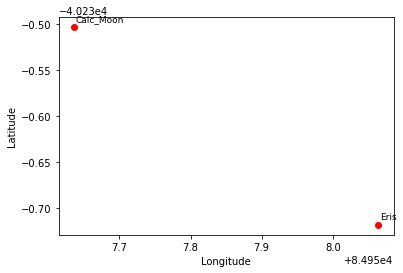

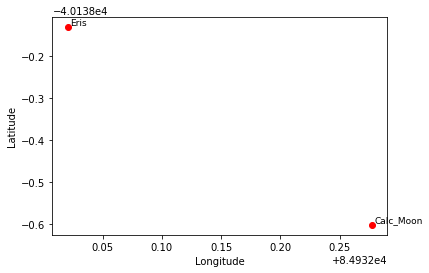

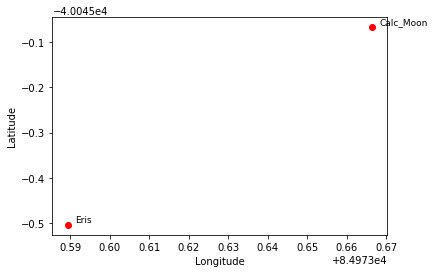

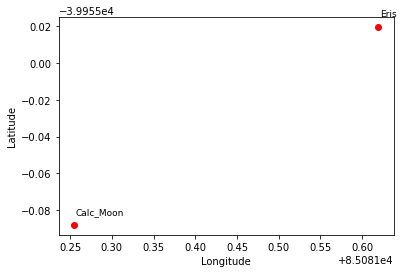

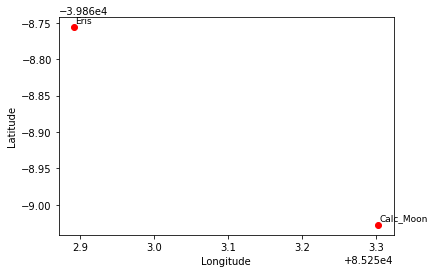

    Primary-Centric Time  deltaLat  deltaLon       Lat1       Lat2       Lon1  \
0           2.459946e+06  0.214861 -0.419807 -11.175199 -11.175140  23.599462   
1           2.459956e+06 -0.469490  0.251732 -11.149481 -11.149611  23.592228   
2           2.459966e+06  0.435403  0.075568 -11.123751 -11.123630  23.603775   
3           2.459976e+06 -0.107232 -0.357834 -11.098606 -11.098636  23.633783   
4           2.459986e+06 -0.271799  0.404193 -11.074654 -11.074730  23.681359   
..                   ...       ...       ...        ...        ...        ...   
68          2.460626e+06  0.023193 -0.410850 -10.883529 -10.883523  24.333048   
69          2.460636e+06 -0.377141  0.365245 -10.867541 -10.867646  24.247178   
70          2.460646e+06  0.502447 -0.086690 -10.848744 -10.848604  24.172572   
71          2.460656e+06 -0.289893 -0.250542 -10.827587 -10.827668  24.111763   
72          2.460666e+06 -0.092334  0.420595 -10.804563 -10.804589  24.066853   

         Lon2         X1   

In [29]:
paramsDF = pd.read_csv('data_points/Eris_radec.csv')

newdf = convert_to_primary_centric(paramsDF,'Eris')
print(newdf)
eris = pd.read_csv('Eris_eph.csv')
print(eris)

In [17]:
#This function makes a scatter plot based on the data given (x,y) data points
def plot_scatter(array,dictionary, words):
    for i in words:
            x, y = array[dictionary[i]]
            plt.scatter(x, y, color = 'red')
            if dictionary[i]==2:
                plt.text(x-0.008,y+0.012,i,fontsize=9)
            else:
                plt.text(x+0.002,y+0.006,i,fontsize=9)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()